In [5]:
# Refresh input files when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# Import Python packages
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from datetime import timedelta

import sklearn.metrics
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import mlflow
# mlflow.sklearn.autolog(disable=True)
# mlflow.statsmodels.autolog(disable=True)
from pathlib import Path

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.graphics.api as smg
from scipy import stats

# Import setup file
from base_include import *
from get_model_data import *
from modelling_functions import *

# features selected in variable_selection notebook
grass_2_hrs_features = ['T_SFC', 'T_SFC_ishistorical', 'RH_SFC', 'WindMagKmh_SFC', 'KBDI', 'ruggedness_average_3km', 'building_density_3km', 'road_density_km_in_3km', 'road_distance_m', 'forest_density_3km', 'shrub_density_3km', 'soil_moisture', 'Curing']
grass_100_ha_features = ['T_SFC', 'DF_SFC', 'WindMagKmh_SFC', 'ruggedness_average_3km', 'building_density_20km', 'road_density_km_in_3km', 'road_distance_m', 'noveg_density_3km', 'distance_to_interface', 'Curing']
forest_4_hrs_features = ['T_SFC', 'KBDI', 'elevation_m', 'road_density_km_in_3km', 'road_distance_m', 'grass_density_3km', 'shrub_density_3km', 'noveg_density_3km', 'distance_to_interface', 'Curing']
forest_5_ha_features = ['RH_SFC', 'DF_SFC', 'WindMagKmh_SFC', 'elevation_m', 'building_density_20km', 'road_density_km_in_3km', 'road_distance_m', 'grass_density_3km']

In [7]:
incidents.shape

(12357, 34)

In [8]:
incidents.columns

Index(['season', 'date', 'reported_time', 'T_SFC', 'RH_SFC', 'WindMagKmh_SFC',
       'DF_SFC', 'KBDI', 'soil_moisture', 'Curing', 'grass_density_3km',
       'forest_density_3km', 'shrub_density_3km', 'noveg_density_3km',
       'primary_fuel_type', 'distance_to_interface', 'elevation_m',
       'ruggedness_average_3km', 'building_density_3km',
       'building_density_20km', 'road_density_km_in_3km', 'road_distance_m',
       'FFDI', 'GFDI', 'uncontrolled_within_2_hrs',
       'uncontrolled_within_4_hrs', 'uncontrolled_within_5_ha',
       'uncontrolled_within_100_ha', 'T_SFC_ishistorical',
       'RH_SFC_ishistorical', 'DF_SFC_ishistorical',
       'WindMagKmh_SFC_ishistorical', 'KBDI_ishistorical',
       'Curing_ishistorical'],
      dtype='object')

## Data summary for paper

In [9]:
count = incidents.groupby('primary_fuel_type').count().season
print(count)
print(count/count.sum()*100)

primary_fuel_type
forest    3812
grass     7580
noveg      522
shrub      443
Name: season, dtype: int64
primary_fuel_type
forest    30.848912
grass     61.341750
noveg      4.224326
shrub      3.585013
Name: season, dtype: float64


C:\Users\et0q\AppData\Local\Temp\ipykernel_42784\854553360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count = incidents.groupby('primary_fuel_type').count().season


In [10]:
count = incidents.query('primary_fuel_type=="grass"').groupby('uncontrolled_within_2_hrs').count().season
print(count)
print(count/count.sum()*100)

uncontrolled_within_2_hrs
0.0    6584
1.0     996
Name: season, dtype: int64
uncontrolled_within_2_hrs
0.0    86.860158
1.0    13.139842
Name: season, dtype: float64


In [11]:
count = incidents.query('primary_fuel_type=="grass"').groupby('uncontrolled_within_100_ha').count().season
print(count)
print(count/count.sum()*100)

uncontrolled_within_100_ha
0.0    7362
1.0     218
Name: season, dtype: int64
uncontrolled_within_100_ha
0.0    97.124011
1.0     2.875989
Name: season, dtype: float64


In [12]:
count = incidents.query('primary_fuel_type=="forest"').groupby('uncontrolled_within_4_hrs').count().season
print(count)
print(count/count.sum()*100)

uncontrolled_within_4_hrs
0.0    2821
1.0     991
Name: season, dtype: int64
uncontrolled_within_4_hrs
0.0    74.003148
1.0    25.996852
Name: season, dtype: float64


In [13]:
count = incidents.query('primary_fuel_type=="forest"').groupby('uncontrolled_within_5_ha').count().season
print(count)
print(count/count.sum()*100)

uncontrolled_within_5_ha
0.0    3237
1.0     575
Name: season, dtype: int64
uncontrolled_within_5_ha
0.0    84.916055
1.0    15.083945
Name: season, dtype: float64


In [14]:
grass_incidents.groupby('season').is_train_data.unique()

season
2007-08    [0]
2008-09    [0]
2009-10    [1]
2010-11    [1]
2011-12    [1]
2012-13    [1]
2013-14    [1]
2014-15    [1]
2015-16    [1]
2016-17    [1]
2017-18    [0]
2018-19    [1]
2019-20    [1]
2020-21    [0]
2021-22    [1]
2022-23    [1]
2023-24    [1]
Name: is_train_data, dtype: object

In [15]:
forest_incidents.groupby('season').is_train_data.unique()

season
2007-08    [0]
2008-09    [0]
2009-10    [1]
2010-11    [1]
2011-12    [1]
2012-13    [1]
2013-14    [1]
2014-15    [1]
2015-16    [1]
2016-17    [1]
2017-18    [0]
2018-19    [1]
2019-20    [1]
2020-21    [0]
2021-22    [1]
2022-23    [1]
2023-24    [1]
Name: is_train_data, dtype: object

In [16]:
grass_incidents.is_train_data.value_counts()/grass_incidents.shape[0]

is_train_data
1    0.841821
0    0.158179
Name: count, dtype: float64

In [17]:
forest_incidents.is_train_data.value_counts()/forest_incidents.shape[0]

is_train_data
1    0.799843
0    0.200157
Name: count, dtype: float64

## Modelling

### Grass

Fraction of data used in training: 0.841820580474934
Num rows in train:  6381 Num rows in test:  1199
Optimization terminated successfully.
         Current function value: 0.321374
         Iterations 7


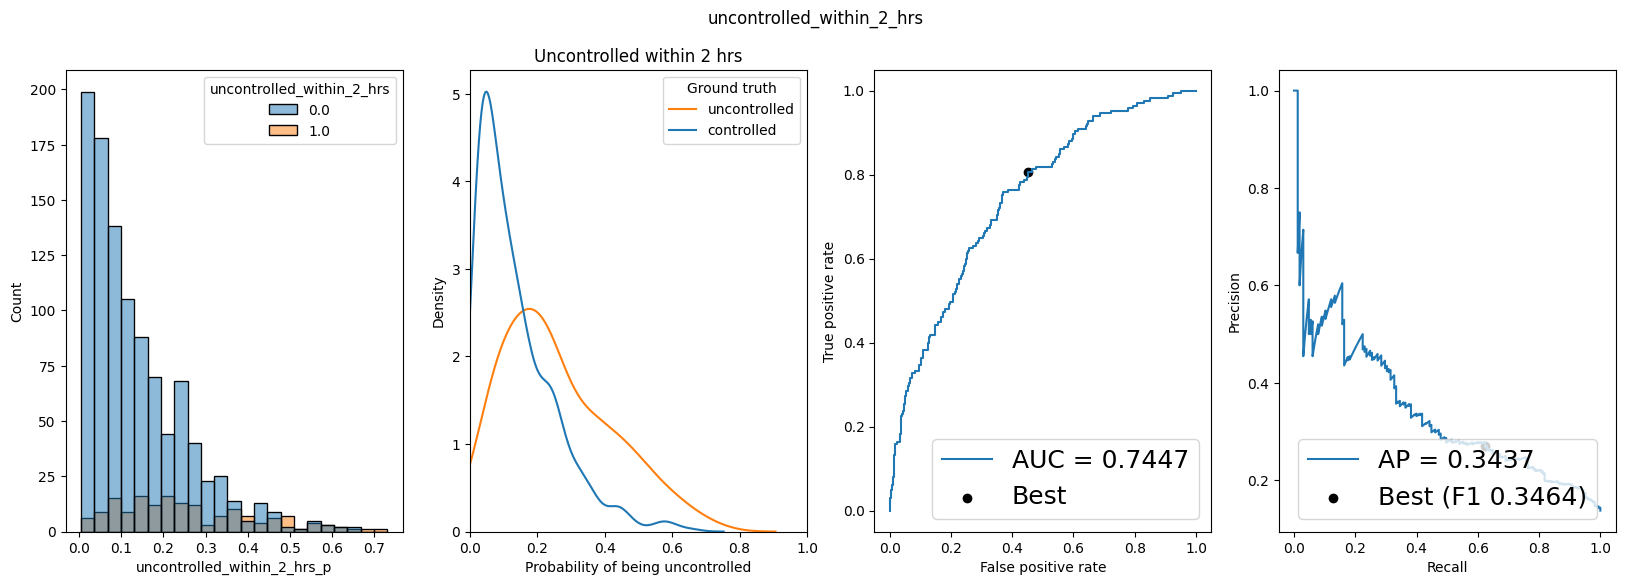

Fraction of data used in training: 0.841820580474934
Num rows in train:  6381 Num rows in test:  1199
Optimization terminated successfully.
         Current function value: 0.097246
         Iterations 10


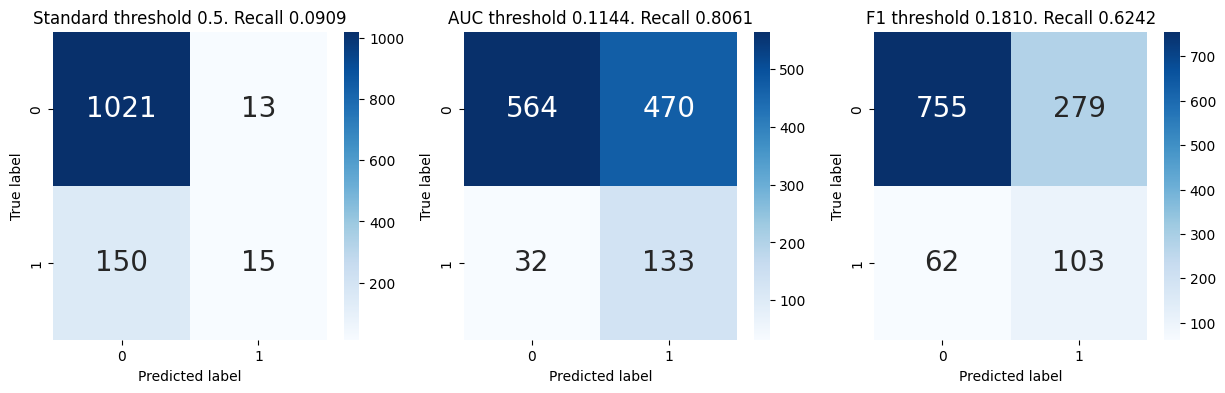

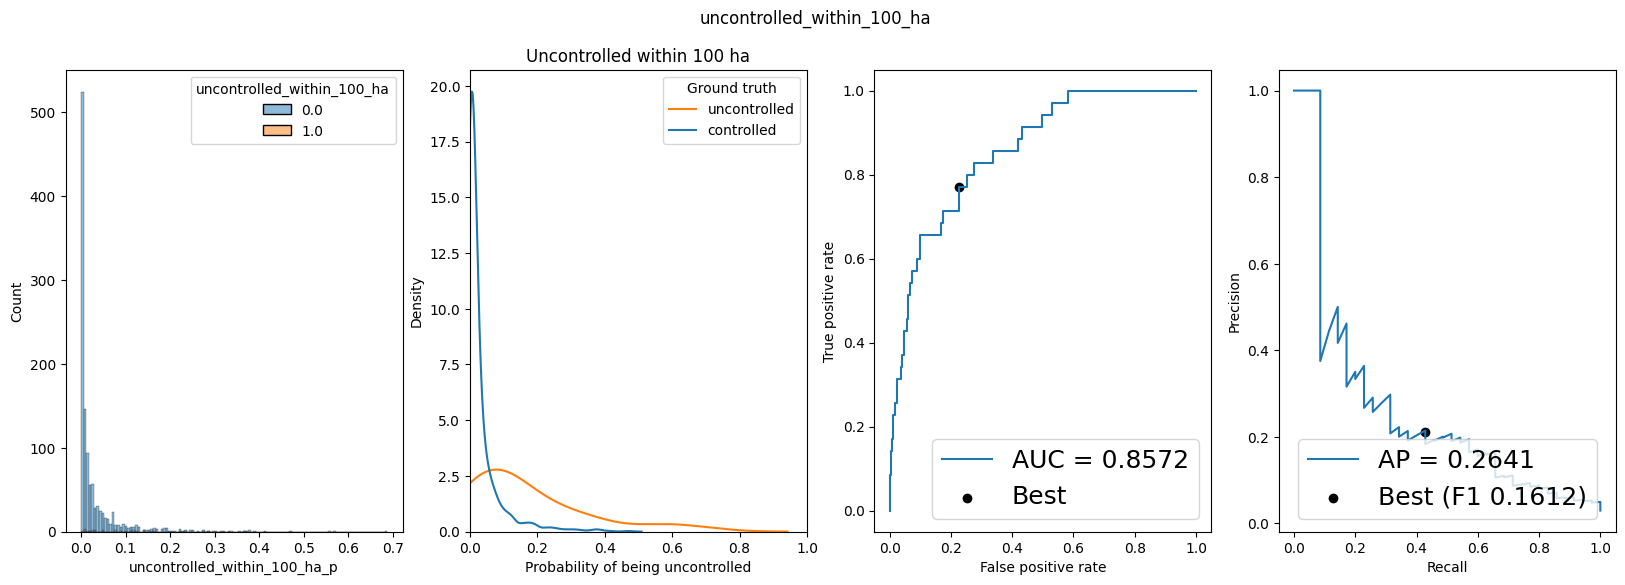

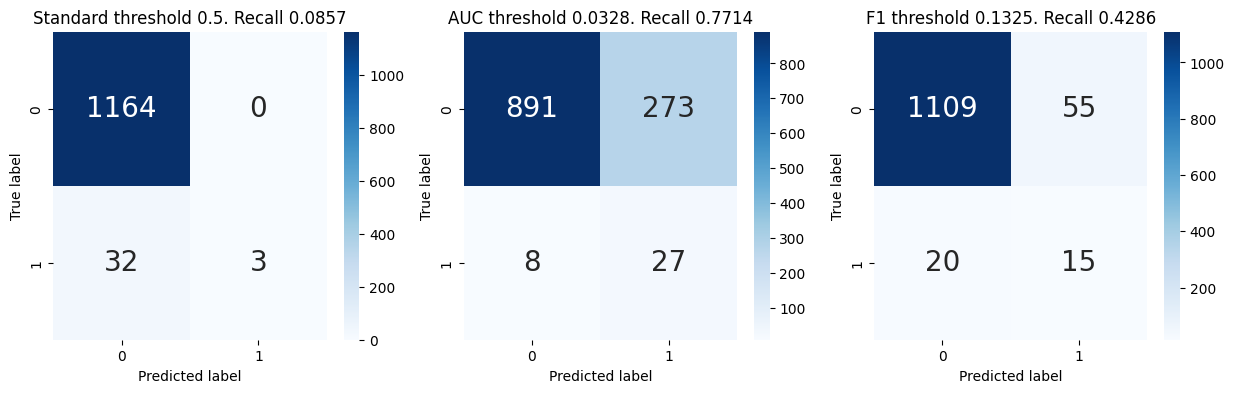

In [2]:
grass_fit = {}
grass_2_hrs_transform_features = ['WindMagKmh_SFC', 'ruggedness_average_3km', 'building_density_3km', 'road_density_km_in_3km', 'road_distance_m', 'shrub_density_3km', 'soil_moisture']
grass_100_ha_transform_features = ['WindMagKmh_SFC', 'ruggedness_average_3km', 'building_density_20km', 'road_density_km_in_3km', 'road_distance_m', 'noveg_density_3km', 'distance_to_interface']
grass_fit['uncontrolled_within_2_hrs'] = fit_logistic_regression(grass_incidents, 'uncontrolled_within_2_hrs', model_features=grass_2_hrs_features, 
                                                                 transform={key: 'np.log1p' for key in grass_2_hrs_transform_features})
get_model_diagnostics(rslt = grass_fit['uncontrolled_within_2_hrs'][0], 
                      incidents_train = grass_fit['uncontrolled_within_2_hrs'][1], 
                      incidents_test = grass_fit['uncontrolled_within_2_hrs'][2],
                      outcome = 'uncontrolled_within_2_hrs',
                      print_diagnostics=True, print_confusion_matrix=True)
grass_fit['uncontrolled_within_100_ha'] = fit_logistic_regression(grass_incidents, 'uncontrolled_within_100_ha', model_features=grass_100_ha_features,
                                                                  transform={key: 'np.log1p' for key in grass_100_ha_transform_features})
get_model_diagnostics(rslt = grass_fit['uncontrolled_within_100_ha'][0], 
                      incidents_train = grass_fit['uncontrolled_within_100_ha'][1], 
                      incidents_test = grass_fit['uncontrolled_within_100_ha'][2],
                      outcome = 'uncontrolled_within_100_ha',
                      print_diagnostics=True, print_confusion_matrix=True)

#### Paper plots and model summary

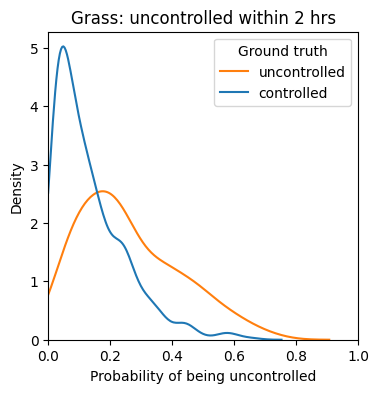

In [19]:
outcome = 'uncontrolled_within_2_hrs'
get_model_diagnostics(rslt = grass_fit[outcome][0], 
                      incidents_train = grass_fit[outcome][1], 
                      incidents_test = grass_fit[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='Grass: ')

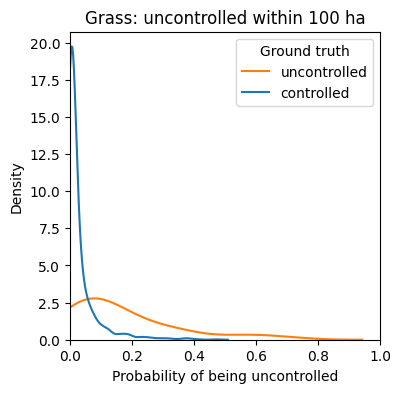

In [20]:
outcome = 'uncontrolled_within_100_ha'
get_model_diagnostics(rslt = grass_fit[outcome][0], 
                      incidents_train = grass_fit[outcome][1], 
                      incidents_test = grass_fit[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='Grass: ')

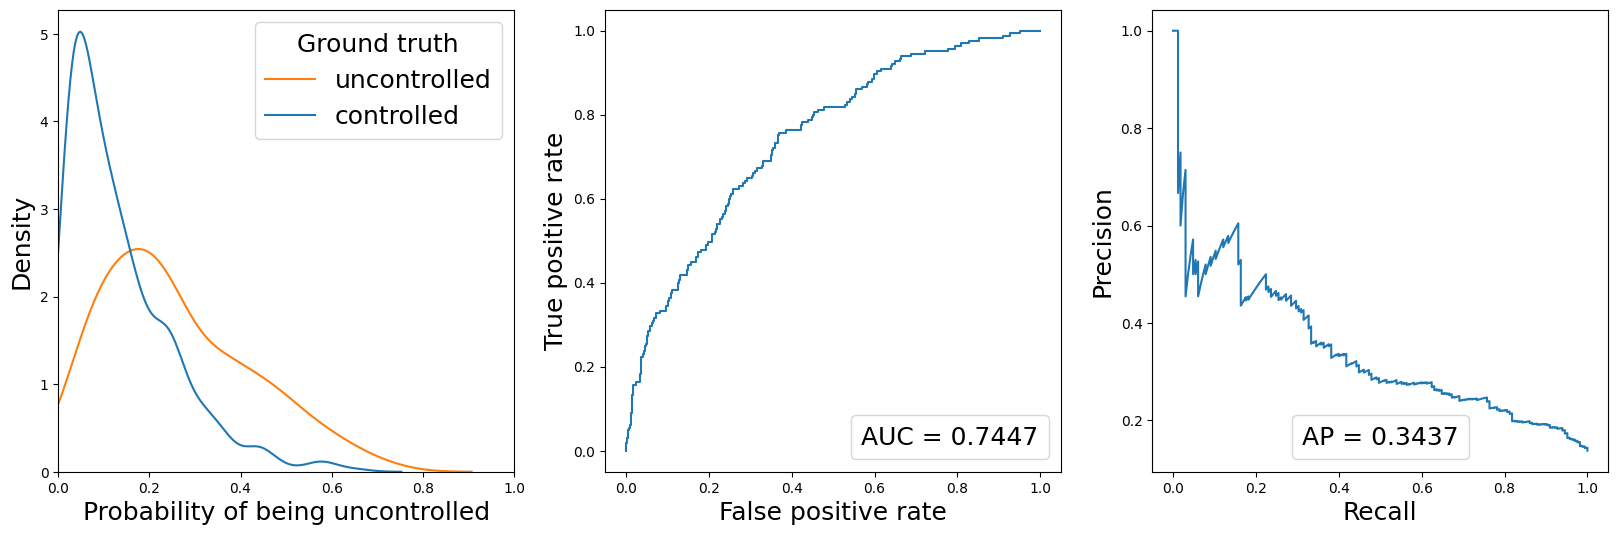

In [21]:
outcome = 'uncontrolled_within_2_hrs'
get_model_diagnostics(rslt = grass_fit[outcome][0], 
                      incidents_train = grass_fit[outcome][1], 
                      incidents_test = grass_fit[outcome][2],
                      outcome = outcome,
                      print_appendix_diagnostics=True)

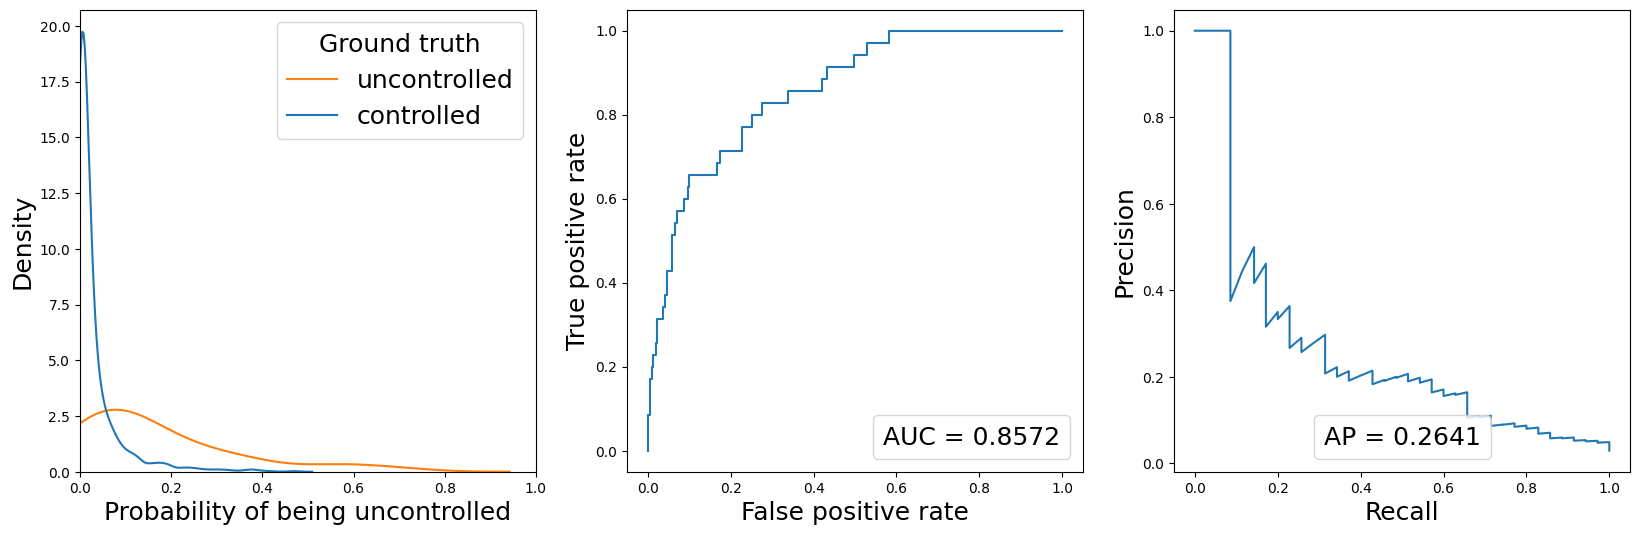

In [22]:
outcome = 'uncontrolled_within_100_ha'
get_model_diagnostics(rslt = grass_fit[outcome][0], 
                      incidents_train = grass_fit[outcome][1], 
                      incidents_test = grass_fit[outcome][2],
                      outcome = outcome,
                      print_appendix_diagnostics=True)

In [23]:
for outcome in ['uncontrolled_within_2_hrs', 'uncontrolled_within_100_ha']:
    print(grass_fit[outcome][0].summary())

                               Logit Regression Results                              
Dep. Variable:     uncontrolled_within_2_hrs   No. Observations:                 6381
Model:                                 Logit   Df Residuals:                     6367
Method:                                  MLE   Df Model:                           13
Date:                       Tue, 14 Jan 2025   Pseudo R-squ.:                  0.1692
Time:                               11:53:01   Log-Likelihood:                -2050.7
converged:                              True   LL-Null:                       -2468.3
Covariance Type:                   nonrobust   LLR p-value:                3.823e-170
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.7005      0.635     -5.826      0.000      -4.945      -2.456
T_SFC    

#### Comparison with GFDI

Fraction of data used in training: 0.843422969929792
Num rows in train:  6367 Num rows in test:  1182
Optimization terminated successfully.
         Current function value: 0.377062
         Iterations 6


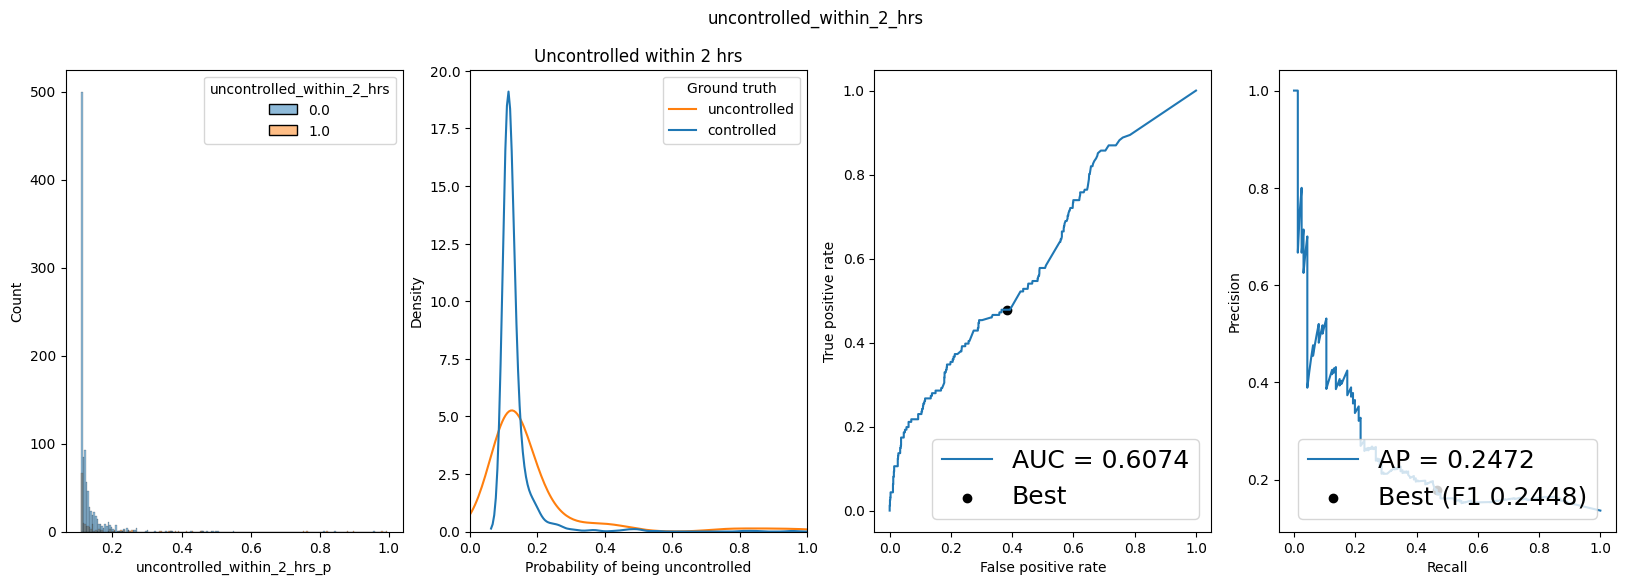

Fraction of data used in training: 0.843422969929792
Num rows in train:  6367 Num rows in test:  1182
Optimization terminated successfully.
         Current function value: 0.120891
         Iterations 8


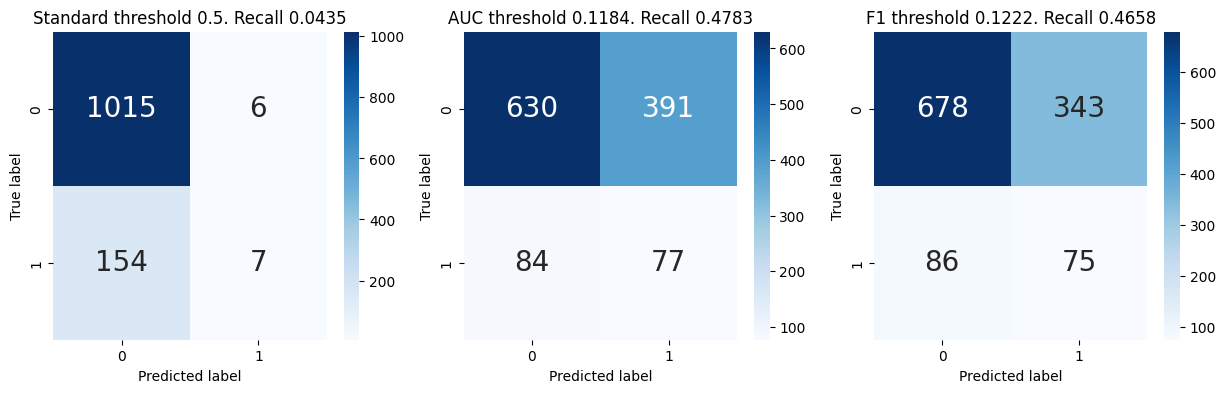

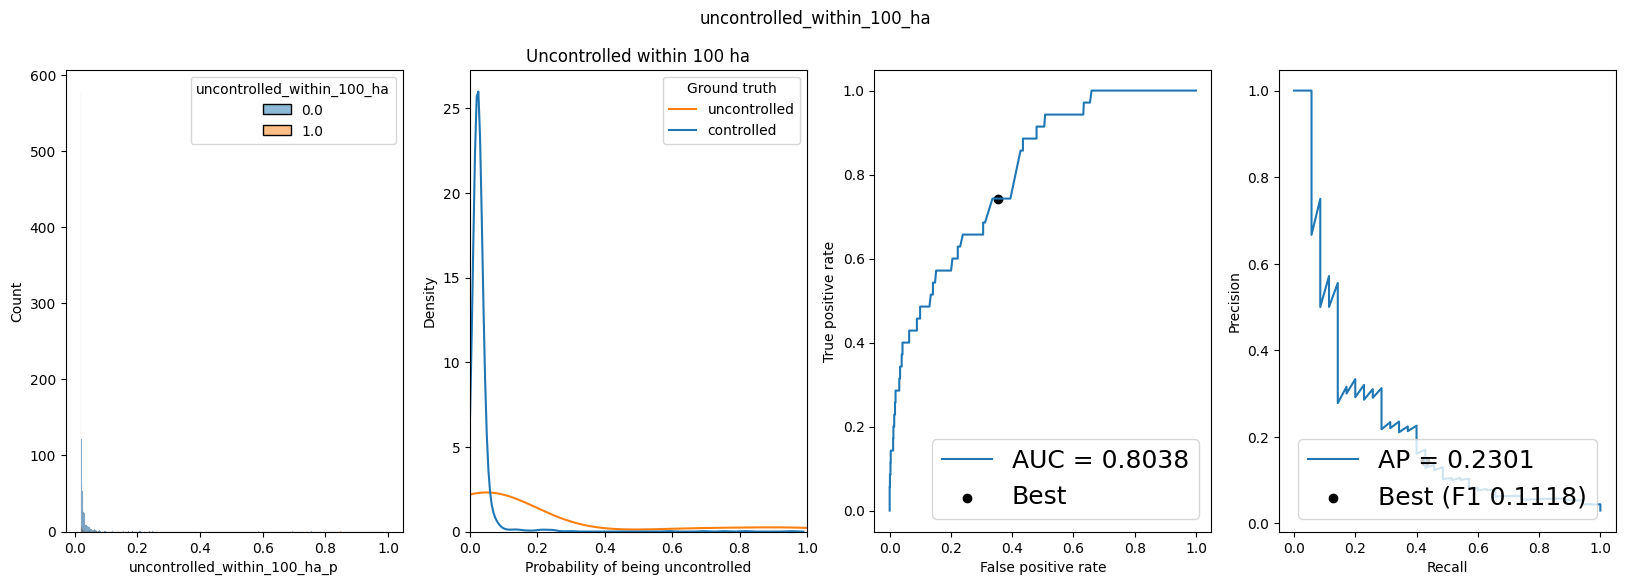

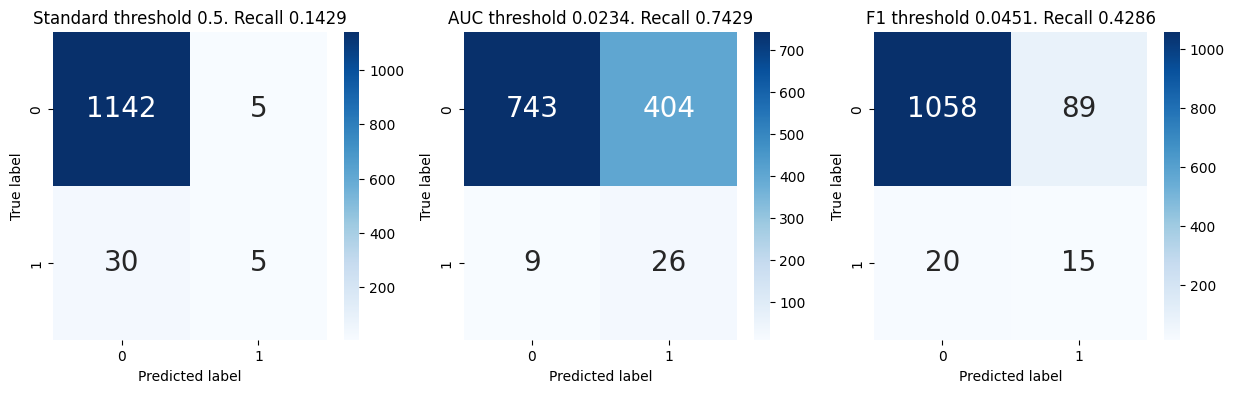

In [24]:
grass_fit_fdi = {}
for outcome in ['uncontrolled_within_2_hrs', 'uncontrolled_within_100_ha']:
    grass_fit_fdi[outcome] = fit_logistic_regression(grass_incidents.dropna(subset='GFDI'), outcome, model_features=['GFDI'])
    get_model_diagnostics(rslt = grass_fit_fdi[outcome][0], 
                          incidents_train = grass_fit_fdi[outcome][1], 
                          incidents_test = grass_fit_fdi[outcome][2],
                          outcome = outcome,
                          print_diagnostics=True, print_confusion_matrix=True)

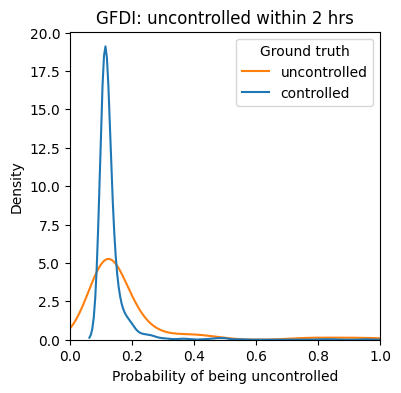

In [25]:
outcome = 'uncontrolled_within_2_hrs'
get_model_diagnostics(rslt = grass_fit_fdi[outcome][0], 
                      incidents_train = grass_fit_fdi[outcome][1], 
                      incidents_test = grass_fit_fdi[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='GFDI: ')

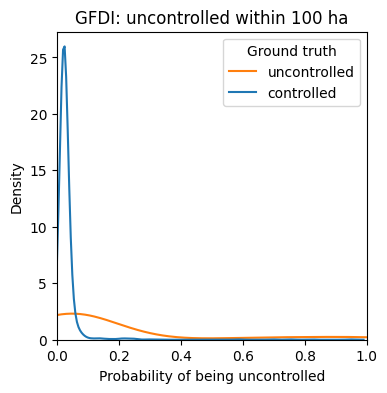

In [26]:
outcome = 'uncontrolled_within_100_ha'
get_model_diagnostics(rslt = grass_fit_fdi[outcome][0], 
                      incidents_train = grass_fit_fdi[outcome][1], 
                      incidents_test = grass_fit_fdi[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='GFDI: ')

### Forest

Fraction of data used in training: 0.7998426023084995
Num rows in train:  3049 Num rows in test:  763
Optimization terminated successfully.
         Current function value: 0.375156
         Iterations 7


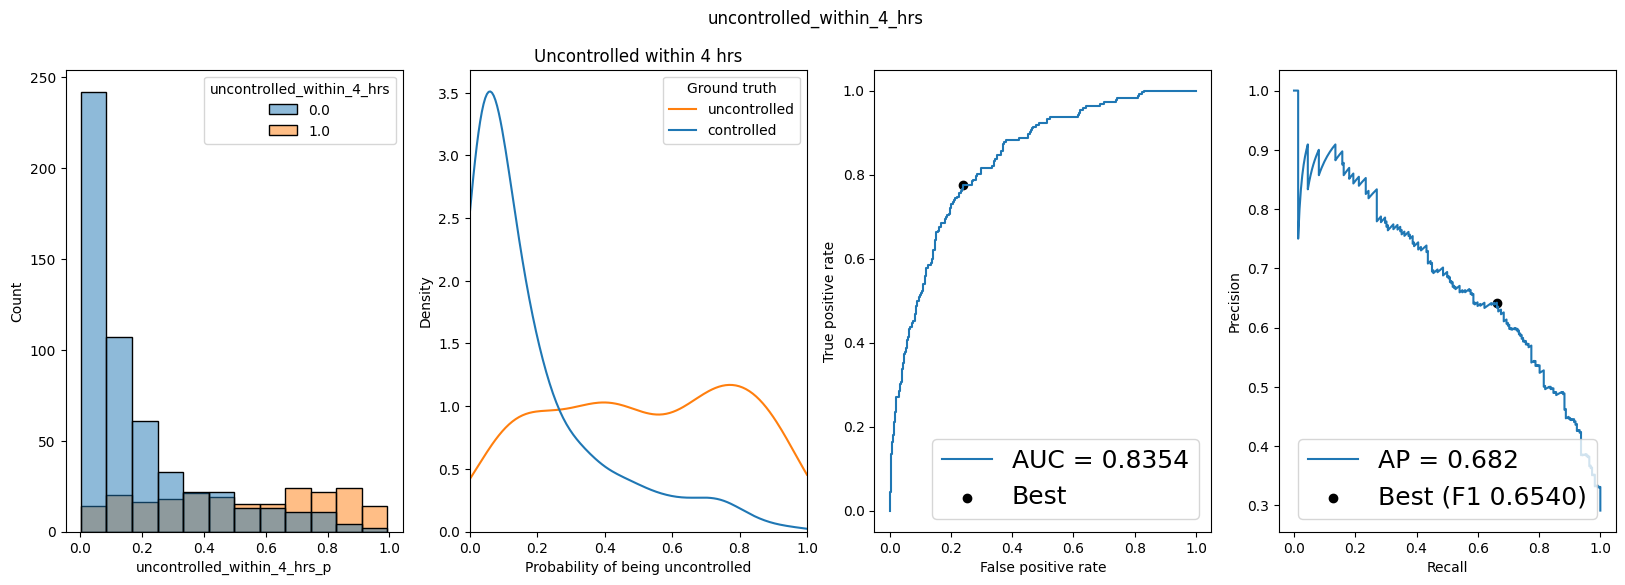

Fraction of data used in training: 0.7998426023084995
Num rows in train:  3049 Num rows in test:  763
Optimization terminated successfully.
         Current function value: 0.348079
         Iterations 7


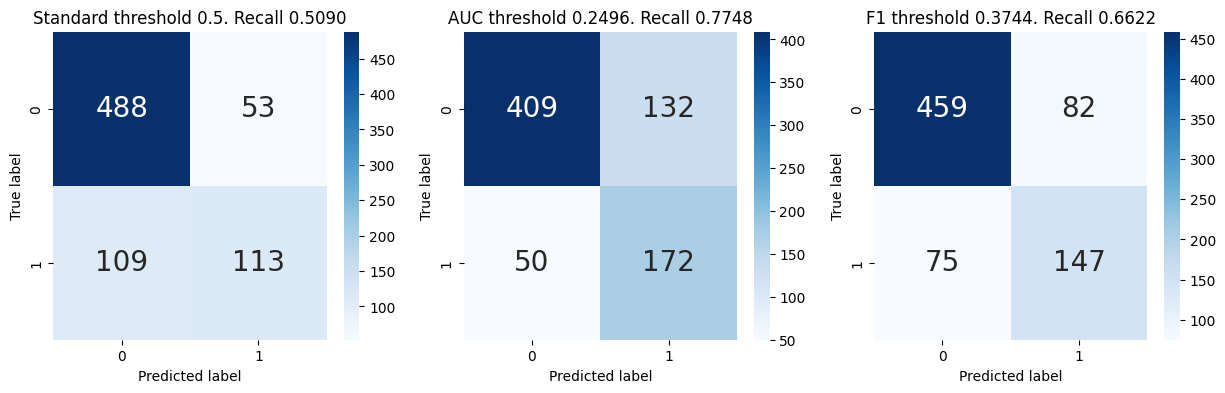

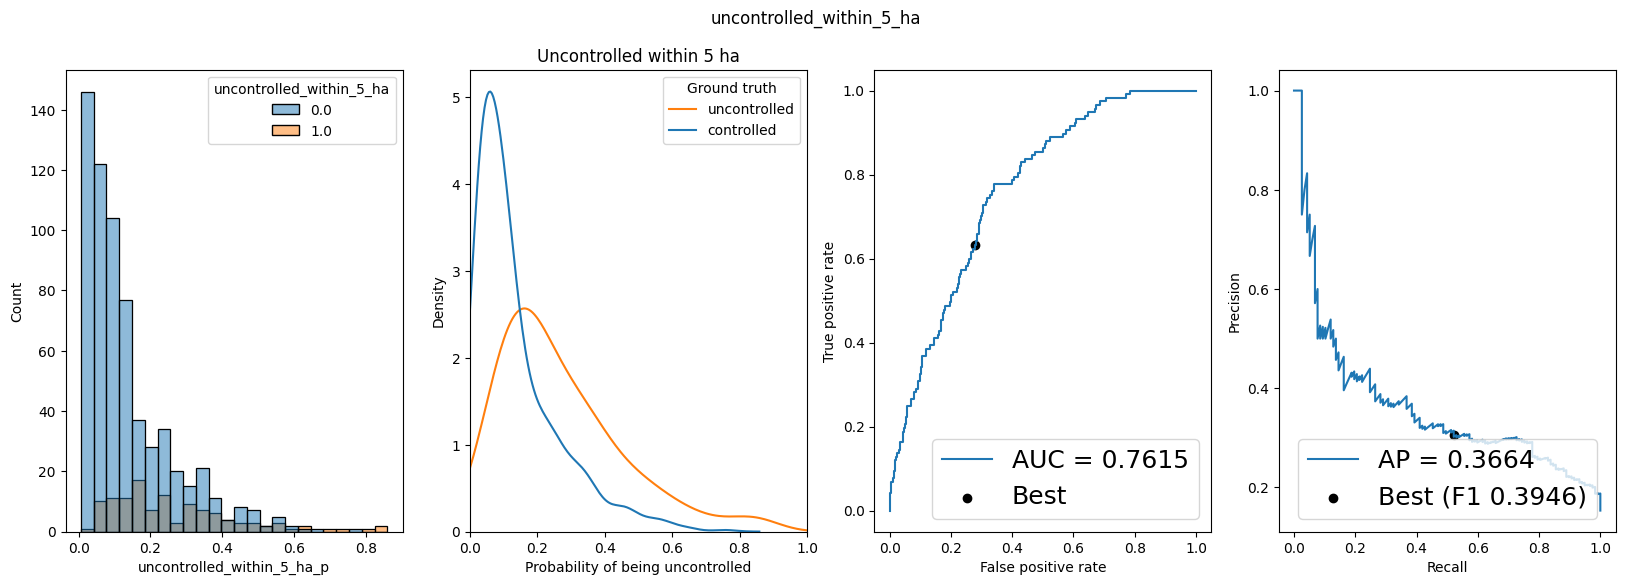

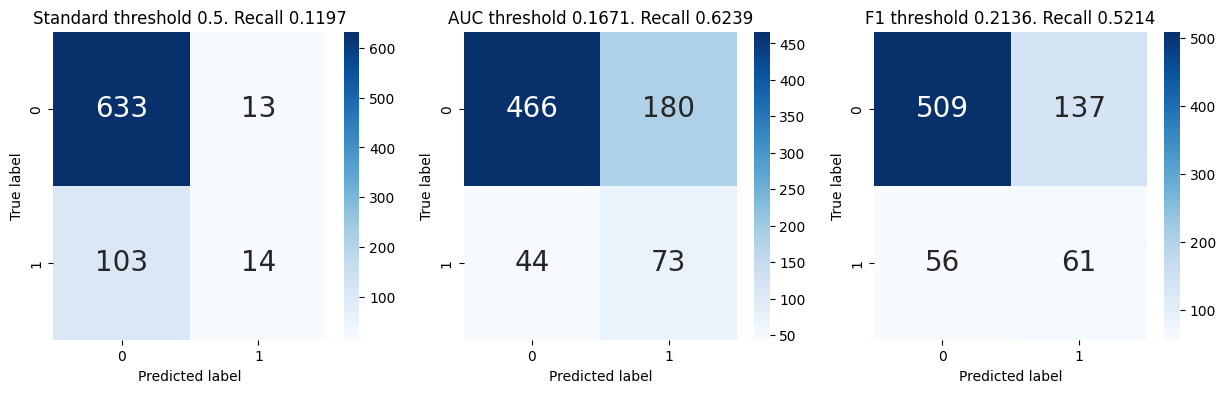

In [27]:
forest_fit = {}
forest_4_hrs_transform_features = ['road_density_km_in_3km', 'road_distance_m', 'noveg_density_3km', 'distance_to_interface']
forest_5_ha_transform_features = ['WindMagKmh_SFC', 'building_density_20km', 'road_density_km_in_3km', 'road_distance_m']
forest_fit['uncontrolled_within_4_hrs'] = fit_logistic_regression(forest_incidents, 'uncontrolled_within_4_hrs', model_features=forest_4_hrs_features, 
                                                                  transform={key: 'np.log1p' for key in forest_4_hrs_transform_features})
get_model_diagnostics(rslt = forest_fit['uncontrolled_within_4_hrs'][0], 
                      incidents_train = forest_fit['uncontrolled_within_4_hrs'][1], 
                      incidents_test = forest_fit['uncontrolled_within_4_hrs'][2],
                      outcome = 'uncontrolled_within_4_hrs',
                      print_diagnostics=True, print_confusion_matrix=True)
forest_fit['uncontrolled_within_5_ha'] = fit_logistic_regression(forest_incidents, 'uncontrolled_within_5_ha', model_features=forest_5_ha_features, 
                                                                 transform={key: 'np.log1p' for key in forest_5_ha_transform_features})
get_model_diagnostics(rslt = forest_fit['uncontrolled_within_5_ha'][0], 
                      incidents_train = forest_fit['uncontrolled_within_5_ha'][1], 
                      incidents_test = forest_fit['uncontrolled_within_5_ha'][2],
                      outcome = 'uncontrolled_within_5_ha',
                      print_diagnostics=True, print_confusion_matrix=True)

#### Paper plots and model summary

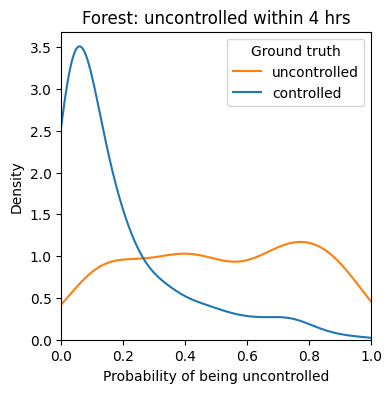

In [28]:
outcome = 'uncontrolled_within_4_hrs'
get_model_diagnostics(rslt = forest_fit[outcome][0], 
                      incidents_train = forest_fit[outcome][1], 
                      incidents_test = forest_fit[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='Forest: ')

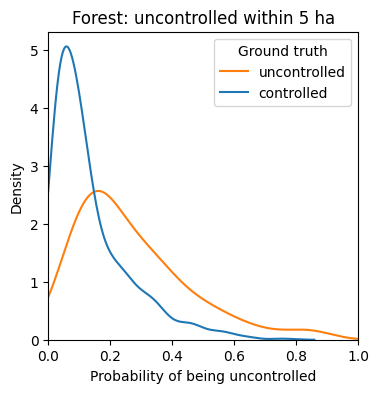

In [29]:
outcome = 'uncontrolled_within_5_ha'
get_model_diagnostics(rslt = forest_fit[outcome][0], 
                      incidents_train = forest_fit[outcome][1], 
                      incidents_test = forest_fit[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='Forest: ')

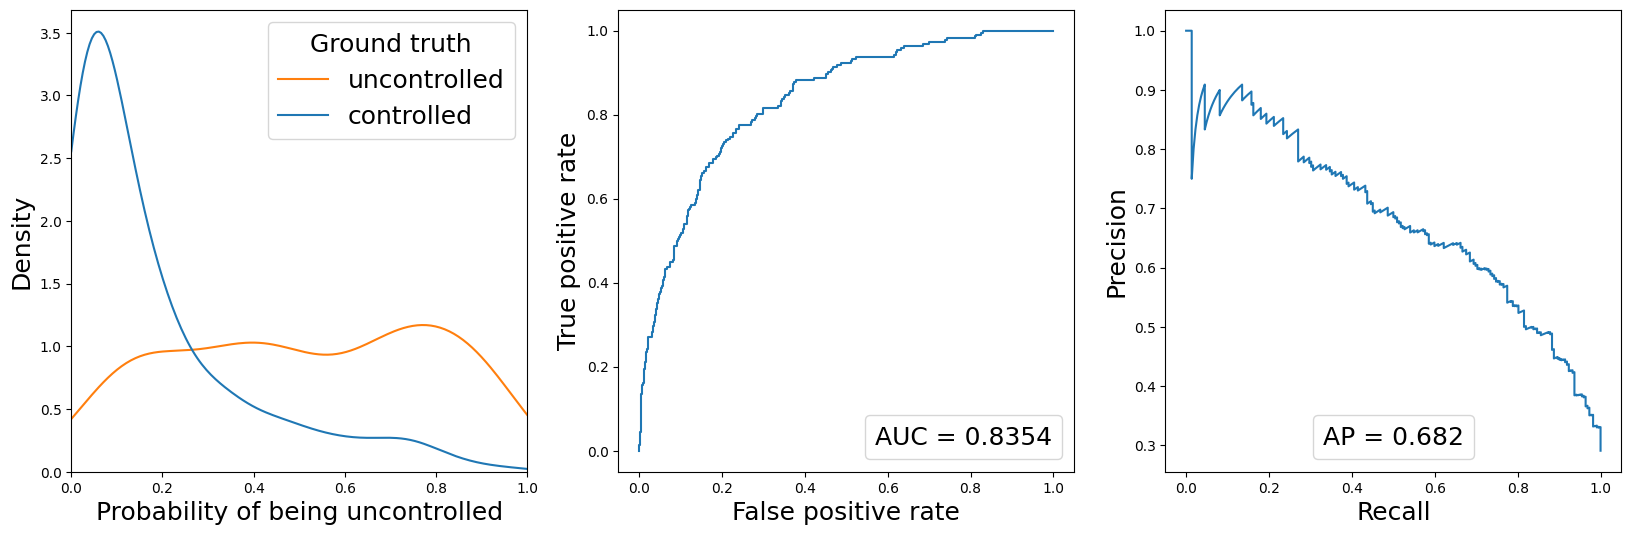

In [30]:
outcome = 'uncontrolled_within_4_hrs'
get_model_diagnostics(rslt = forest_fit[outcome][0], 
                      incidents_train = forest_fit[outcome][1], 
                      incidents_test = forest_fit[outcome][2],
                      outcome = outcome,
                      print_appendix_diagnostics=True)

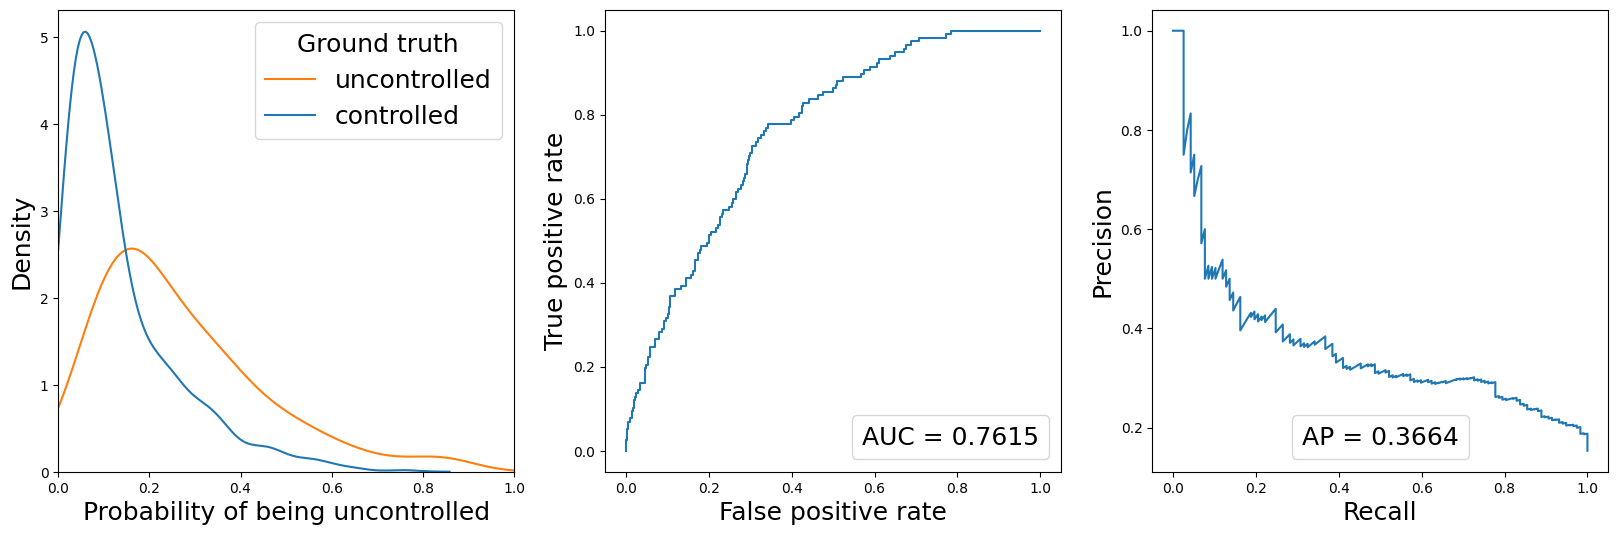

In [31]:
outcome = 'uncontrolled_within_5_ha'
get_model_diagnostics(rslt = forest_fit[outcome][0], 
                      incidents_train = forest_fit[outcome][1], 
                      incidents_test = forest_fit[outcome][2],
                      outcome = outcome,
                      print_appendix_diagnostics=True)

In [32]:
for outcome in ['uncontrolled_within_4_hrs', 'uncontrolled_within_5_ha']:
    print(forest_fit[outcome][0].summary())

                               Logit Regression Results                              
Dep. Variable:     uncontrolled_within_4_hrs   No. Observations:                 3049
Model:                                 Logit   Df Residuals:                     3038
Method:                                  MLE   Df Model:                           10
Date:                       Tue, 14 Jan 2025   Pseudo R-squ.:                  0.3357
Time:                               11:53:07   Log-Likelihood:                -1143.9
converged:                              True   LL-Null:                       -1721.9
Covariance Type:                   nonrobust   LLR p-value:                4.091e-242
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5778      0.512      1.129      0.259      -0.426       1.581
T_SFC    

#### Comparison with FFDI

Fraction of data used in training: 0.7998426023084995
Num rows in train:  3049 Num rows in test:  763
Optimization terminated successfully.
         Current function value: 0.564299
         Iterations 5


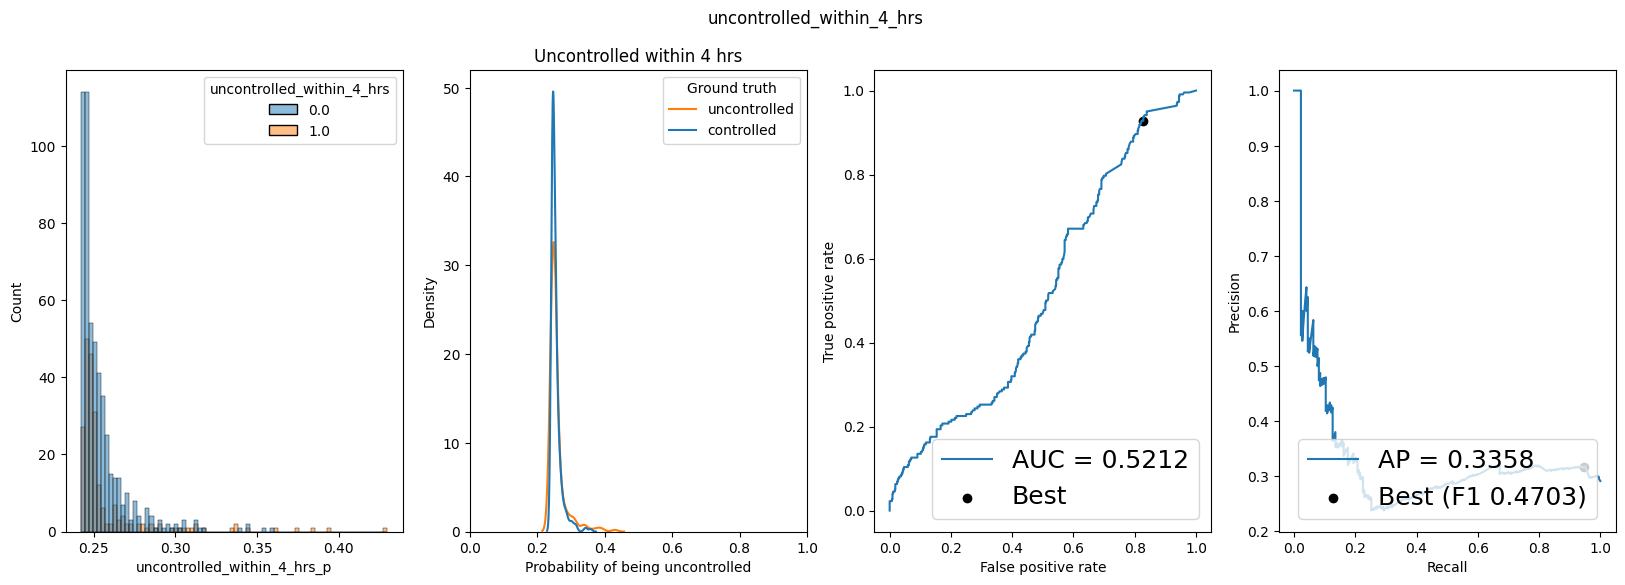

C:\Users\et0q\OneDrive - Department of Energy, Environment and Climate Action\Projects\suppression\vic-ia\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fraction of data used in training: 0.7998426023084995
Num rows in train:  3049 Num rows in test:  763
Optimization terminated successfully.
         Current function value: 0.420182
         Iterations 6


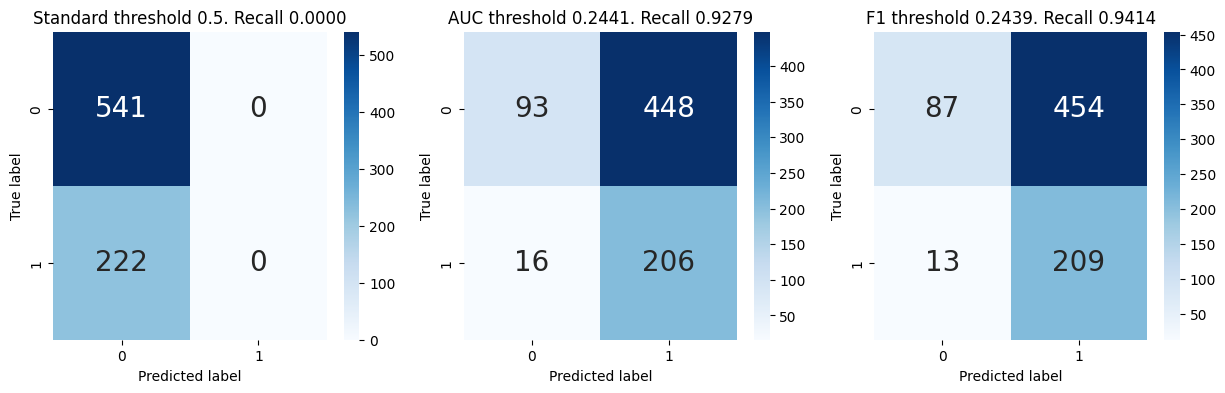

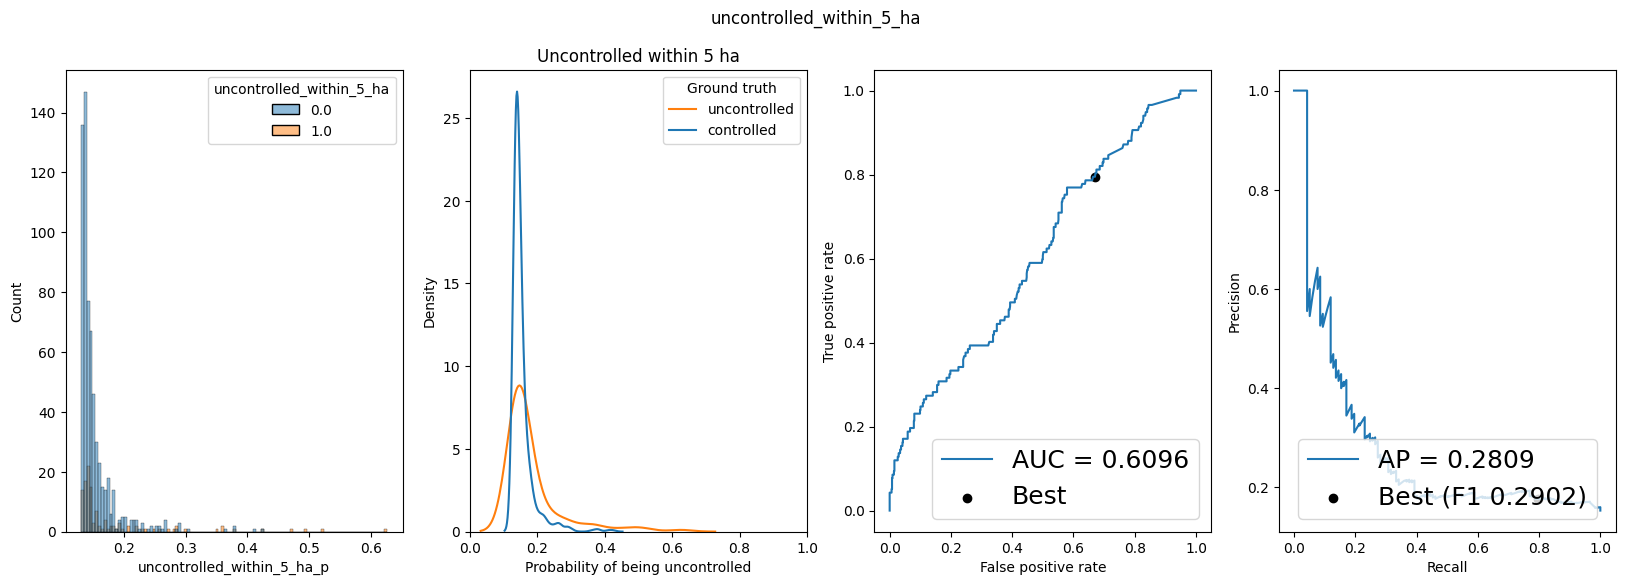

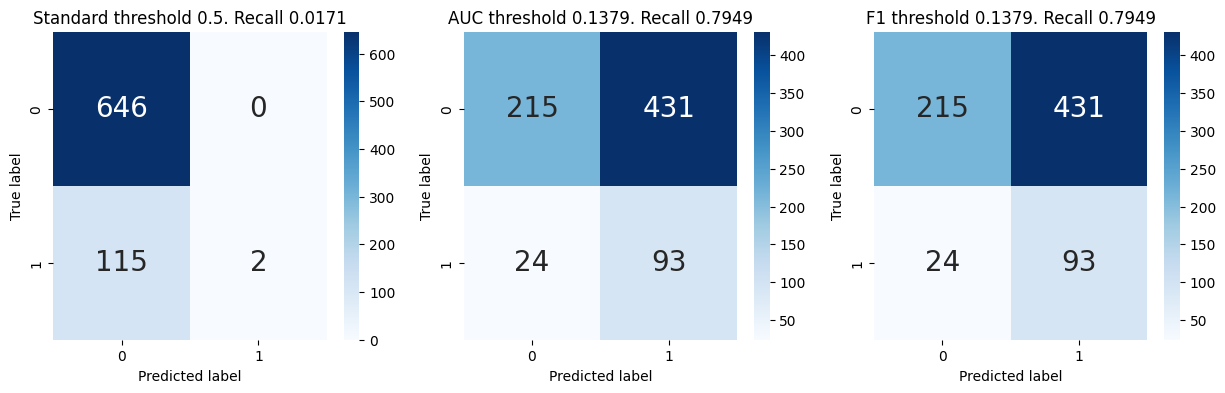

In [33]:
forest_fit_fdi = {}
for outcome in ['uncontrolled_within_4_hrs', 'uncontrolled_within_5_ha']:
    forest_fit_fdi[outcome] = fit_logistic_regression(forest_incidents, outcome, model_features=['FFDI'])
    get_model_diagnostics(rslt = forest_fit_fdi[outcome][0], 
                          incidents_train = forest_fit_fdi[outcome][1], 
                          incidents_test = forest_fit_fdi[outcome][2],
                          outcome = outcome,
                          print_diagnostics=True, print_confusion_matrix=True)

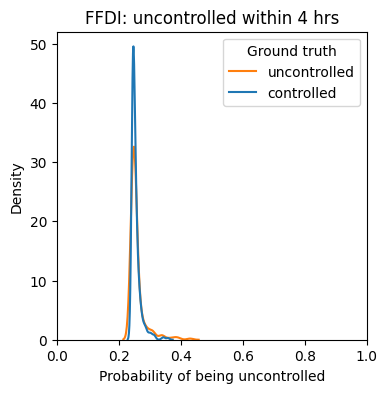

In [34]:
outcome = 'uncontrolled_within_4_hrs'
get_model_diagnostics(rslt = forest_fit_fdi[outcome][0], 
                      incidents_train = forest_fit_fdi[outcome][1], 
                      incidents_test = forest_fit_fdi[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='FFDI: ')

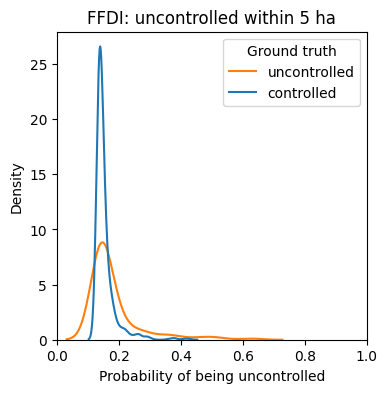

In [35]:
outcome = 'uncontrolled_within_5_ha'
get_model_diagnostics(rslt = forest_fit_fdi[outcome][0], 
                      incidents_train = forest_fit_fdi[outcome][1], 
                      incidents_test = forest_fit_fdi[outcome][2],
                      outcome = outcome,
                      print_density=True,
                      model_name_text='FFDI: ')

## Model testing

### Colinearity

VIF exceeding 5 or 10 suggests a problematic amount of collinearity (from ISLP). All the VIF scores are less than 5, so don't have collinearity issues.

In [36]:
compute_vif(grass_incidents, grass_features)

Variable       VIF
2                   RH_SFC  3.924739
5                     KBDI  3.724756
0                    T_SFC  3.588952
3                   DF_SFC  3.455136
10  road_density_km_in_3km  3.377957
9     building_density_3km  2.367769
17                  Curing  1.965191
7   ruggedness_average_3km  1.747161
14       noveg_density_3km  1.718591
1       T_SFC_ishistorical  1.714671
8    building_density_20km  1.693361
6              elevation_m  1.639565
16           soil_moisture  1.474696
12      forest_density_3km  1.474578
11         road_distance_m  1.143605
4           WindMagKmh_SFC  1.118885
15   distance_to_interface  1.110701
13       shrub_density_3km  1.095717

In [37]:
compute_vif(forest_incidents, forest_features)

Variable       VIF
10  road_density_km_in_3km  4.654589
5                     KBDI  3.556433
3                   DF_SFC  3.204463
0                    T_SFC  3.043827
2                   RH_SFC  3.013756
14       noveg_density_3km  3.009326
9     building_density_3km  2.990292
7   ruggedness_average_3km  2.330033
8    building_density_20km  2.138975
17                  Curing  1.917002
12       grass_density_3km  1.913204
6              elevation_m  1.821370
13       shrub_density_3km  1.577770
15   distance_to_interface  1.503114
1       T_SFC_ishistorical  1.502998
16           soil_moisture  1.484818
11         road_distance_m  1.337826
4           WindMagKmh_SFC  1.115144

### Residuals

- Residuals look pretty flat and even above/below. 100 ha outcome possibly exhibiting cone-like structure, but I think that's more skewing than cone.

C:\Users\et0q\OneDrive - Department of Energy, Environment and Climate Action\Projects\suppression\vic-ia\venv\Lib\site-packages\matplotlib\scale.py:153: RuntimeWarning: invalid value encountered in log1p
  return self._forward(values)


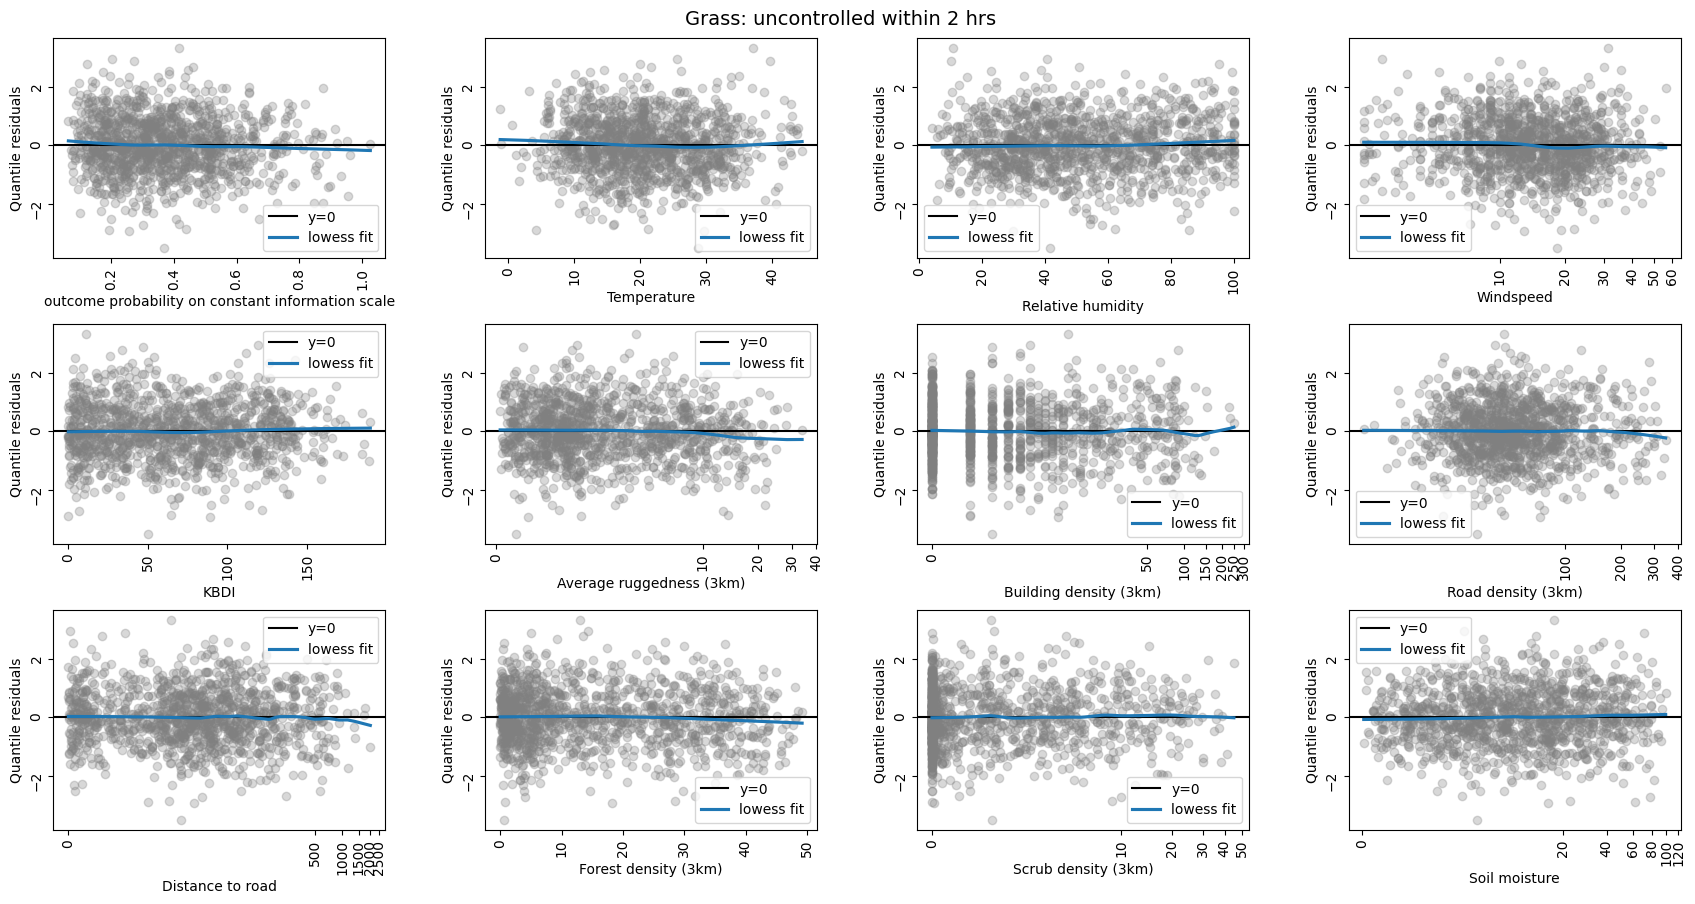

In [38]:
outcome = 'uncontrolled_within_2_hrs'
features = [x for x in grass_2_hrs_features if x != 'T_SFC_ishistorical']
plot_quantile_residuals(grass_fit[outcome][2], outcome, outcome + '_p', features, log_transform=grass_2_hrs_transform_features, model_name_text='Grass: ')

C:\Users\et0q\OneDrive - Department of Energy, Environment and Climate Action\Projects\suppression\vic-ia\venv\Lib\site-packages\matplotlib\scale.py:153: RuntimeWarning: invalid value encountered in log1p
  return self._forward(values)


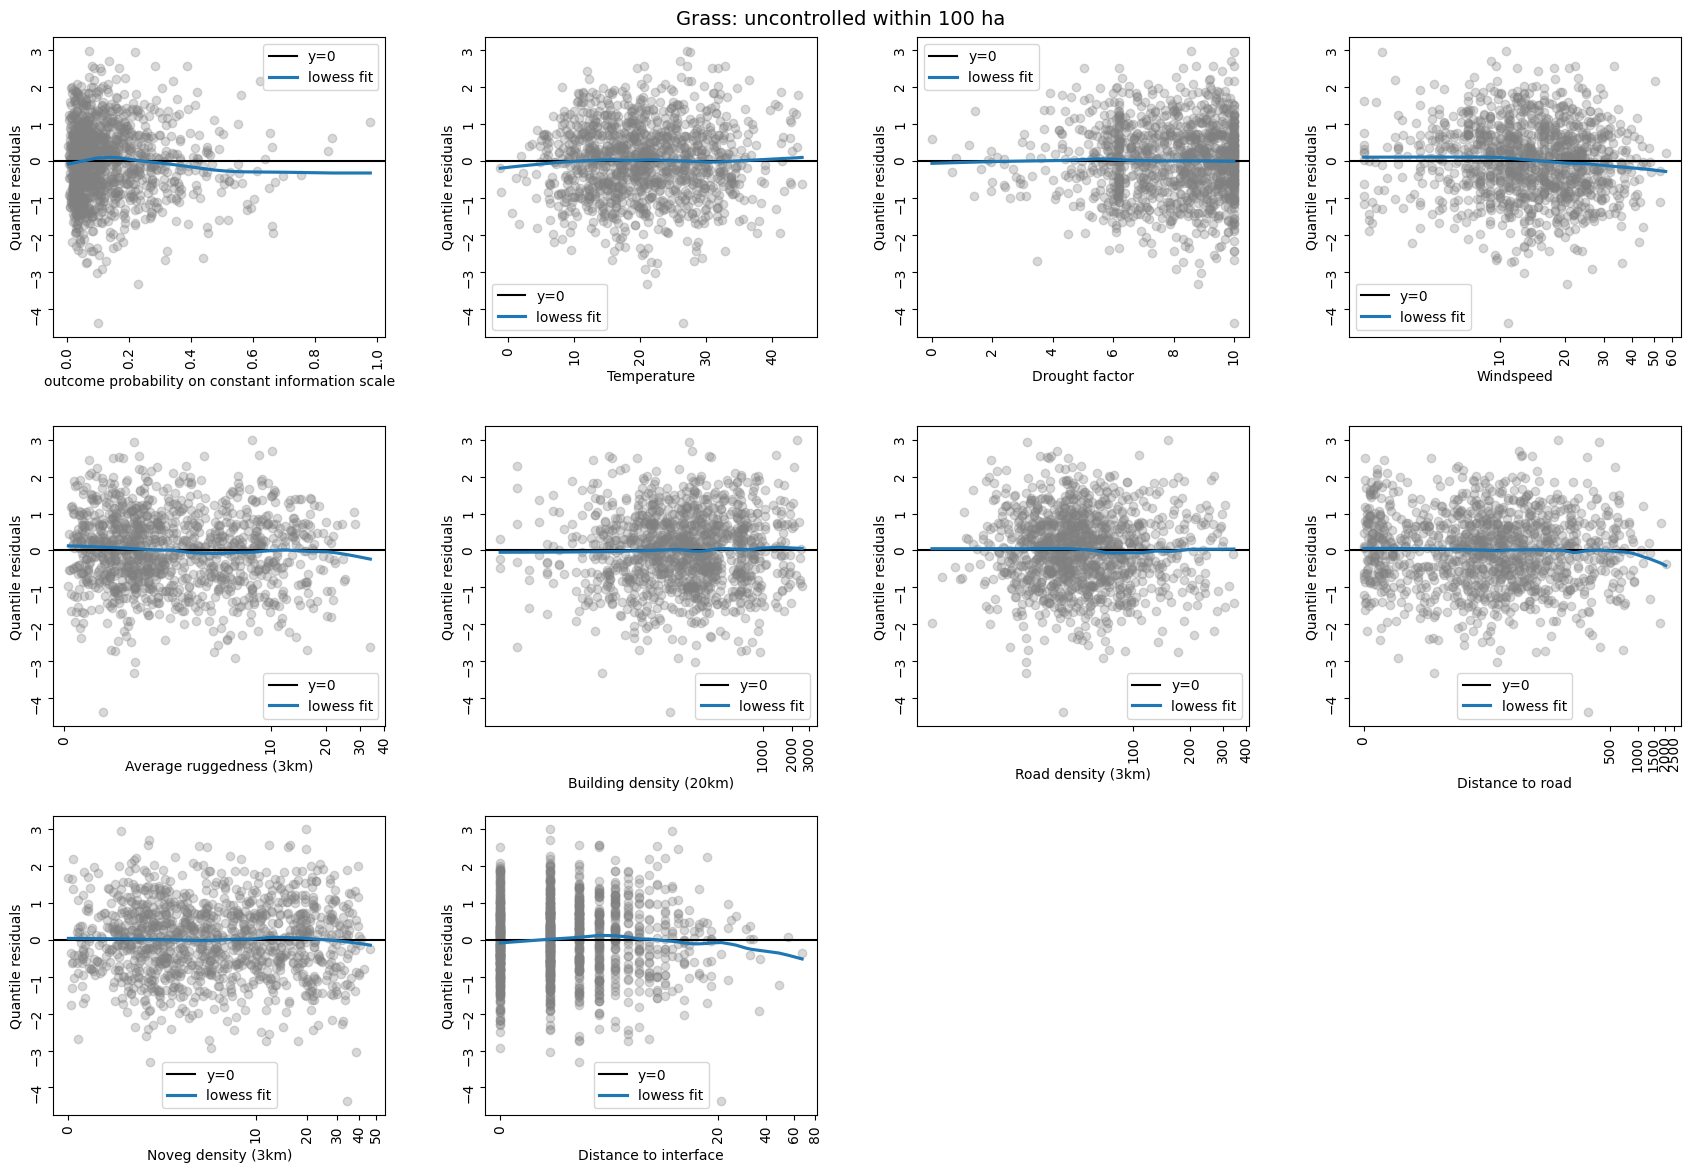

In [39]:
outcome = 'uncontrolled_within_100_ha'
plot_quantile_residuals(grass_fit[outcome][2], outcome, outcome + '_p', grass_100_ha_features, log_transform=grass_100_ha_transform_features, model_name_text='Grass: ')

C:\Users\et0q\OneDrive - Department of Energy, Environment and Climate Action\Projects\suppression\vic-ia\venv\Lib\site-packages\matplotlib\scale.py:153: RuntimeWarning: invalid value encountered in log1p
  return self._forward(values)


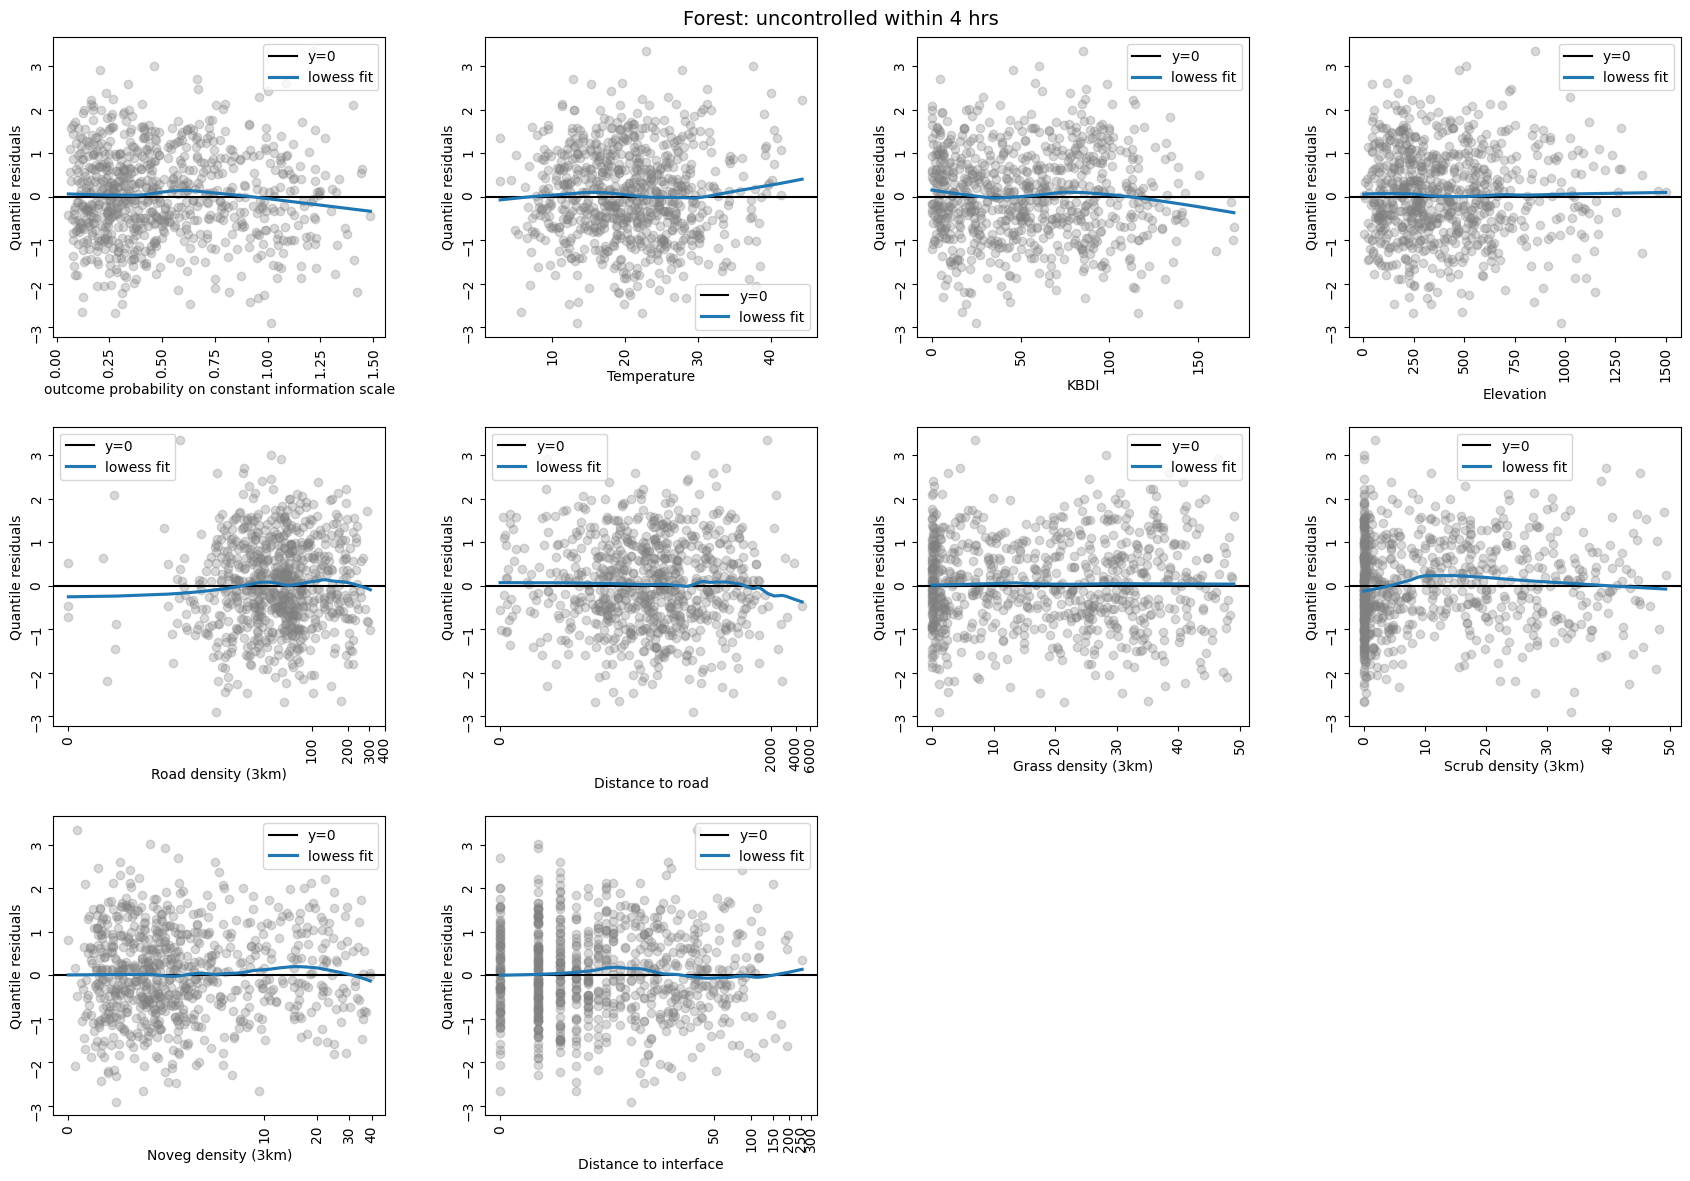

In [40]:
outcome = 'uncontrolled_within_4_hrs'
plot_quantile_residuals(forest_fit[outcome][2], outcome, outcome + '_p', forest_4_hrs_features, log_transform=forest_4_hrs_transform_features, model_name_text='Forest: ')

C:\Users\et0q\OneDrive - Department of Energy, Environment and Climate Action\Projects\suppression\vic-ia\venv\Lib\site-packages\matplotlib\scale.py:153: RuntimeWarning: invalid value encountered in log1p
  return self._forward(values)


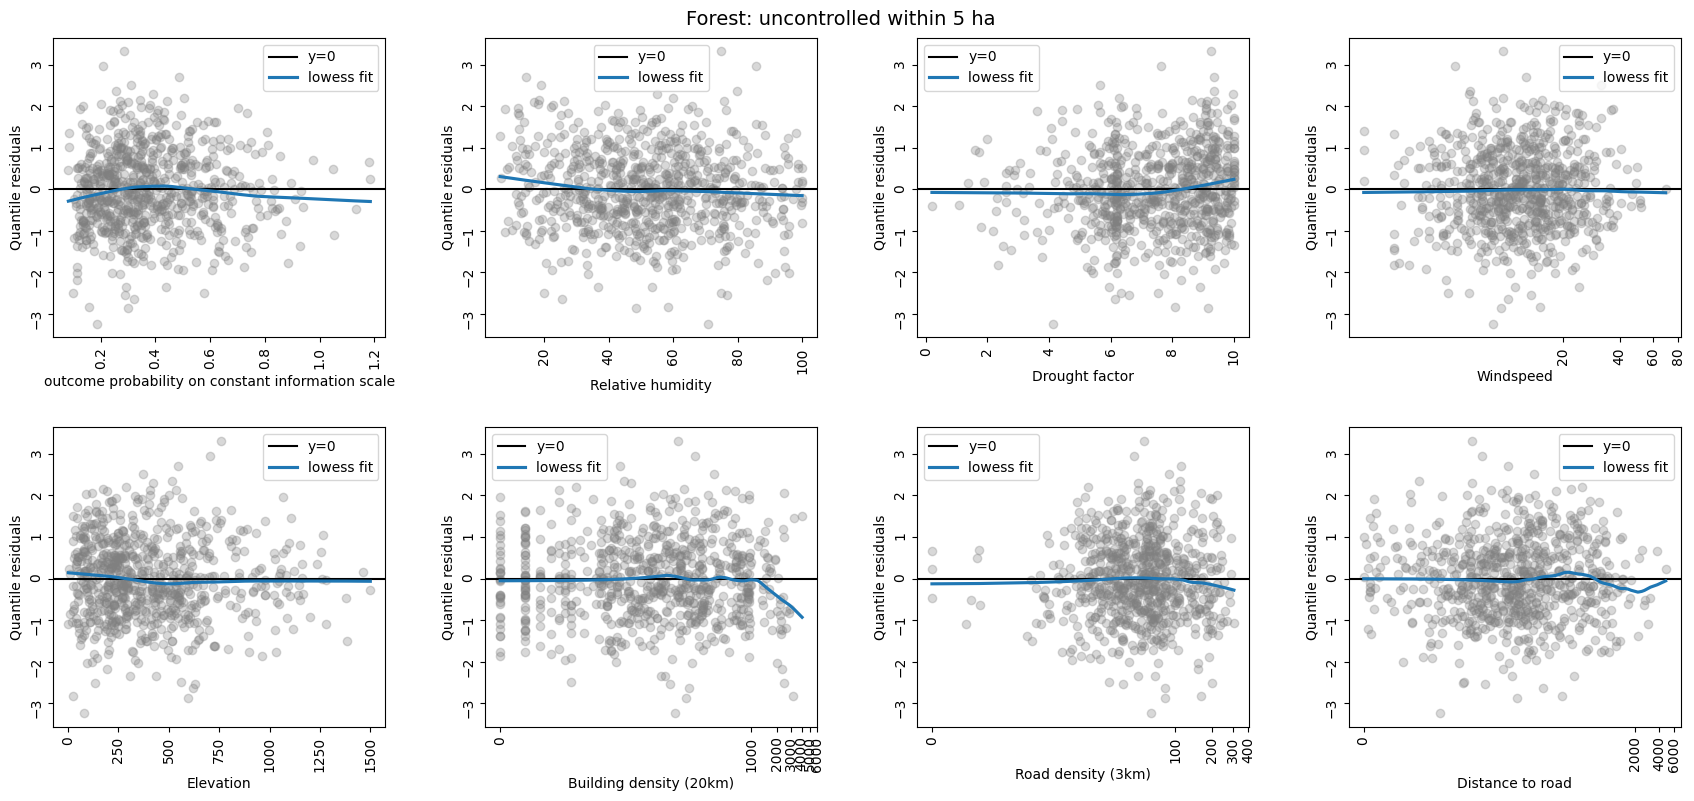

In [41]:
outcome = 'uncontrolled_within_5_ha'
plot_quantile_residuals(forest_fit[outcome][2], outcome, outcome + '_p', forest_5_ha_features, log_transform=forest_5_ha_transform_features, model_name_text='Forest: ')